In [0]:
SANDBOX_NAME = # Sandbox Name
DATA_PATH = "/data/sandboxes/"+SANDBOX_NAME+"/data/"



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [0]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)




## Lectura de datos

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Leemos todas las tablas csv

In [181]:
diabetes = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/diabetic_data.csv', sep=',')
diabetes.head(2)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30


In [182]:
admission_source = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/admission_source_id.csv', sep=',')
admission_source.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [0]:
admission_type = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/admission_type_id.csv', sep=',')
admission_type.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [0]:
discharge_disposition = pd.read_csv('/content/drive/My Drive/Data/dataset_diabetes/discharge_disposition_id.csv', sep=',')
discharge_disposition.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


In [0]:
type(admission_source) #comprobamos con uno de ellos, que efectivamente es un dataframe

pandas.core.frame.DataFrame



### Comprobar correcta lectura de los datos

Antes que nada se almacena en una variable llamada dim_tabla, la dimensión de lo que se ha importado.

In [0]:
dim_diabetes=diabetes.shape
dim_diabetes

(101766, 50)

In [0]:
dim_admission_source=admission_source.shape
dim_admission_source

(25, 2)

In [0]:
dim_admission_type=admission_type.shape
dim_admission_type

(8, 2)

In [0]:
dim_discharge_disposition=discharge_disposition.shape
dim_discharge_disposition

(30, 2)

In [0]:
print(diabetes.head())




In [0]:
print(admission_source.head())


   admission_source_id                                      description
0  1                     Physician Referral                            
1  2                    Clinic Referral                                
2  3                    HMO Referral                                   
3  4                    Transfer from a hospital                       
4  5                     Transfer from a Skilled Nursing Facility (SNF)


In [0]:
print(admission_type.head())


   admission_type_id    description
0  1                  Emergency    
1  2                  Urgent       
2  3                  Elective     
3  4                  Newborn      
4  5                  Not Available


In [0]:
print(discharge_disposition.head())

   discharge_disposition_id  \
0  1                          
1  2                          
2  3                          
3  4                          
4  5                          

                                                            description  
0  Discharged to home                                                    
1  Discharged/transferred to another short term hospital                 
2  Discharged/transferred to SNF                                         
3  Discharged/transferred to ICF                                         
4  Discharged/transferred to another type of inpatient care institution  


Se ha comprobado que la tabla principal no tiene registros que no se deban importar. 
Revisadas cabeceras y separadores. Se pueden importar como están aunque los nombres de variable se deberán cambiar en algún caso.



### Juntar todos los datos en el mismo DataFrame

Vemos que hay una tabla principal, diabetes, y tres tablas accesorias. Cada una de las tablas accesorias tiene un id que está en la tabla principal. Vinculamos por id, sin repetir el propio id, de forma que se carguen solo las 3 descripciones

In [0]:
#unimos diabetes con admission source
diabetes_adm=pd.merge(diabetes,admission_source, on=['admission_source_id'], how='left')
diabetes_adm.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,Emergency Room


In [0]:
print(diabetes.shape)
print(admission_source.shape)
print(diabetes_adm.shape) #analizamos un poco el resultado

(101766, 50)
(25, 2)
(101766, 51)


In [0]:
#unimos diabetes_adm con admission_type 
diabetes_adm_type=pd.merge(diabetes_adm,admission_type, on=['admission_type_id'], how='outer')
diabetes_adm_type.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_x,description_y
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,NO,Physician Referral,None
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,No,No,No,No,Ch,Yes,>30,Physician Referral,None
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,...,No,No,No,No,No,Ch,Yes,NO,Emergency Room,None


In [0]:
print(diabetes_adm.shape)
print(admission_type.shape)
print(diabetes_adm_type.shape) #analizamos un poco el resultado del segundo merge

(101766, 51)
(8, 2)
(101766, 52)


In [0]:
#unimos diabetes_adm_type con discharge_disposition 
diabetes_completo=pd.merge(diabetes_adm_type,discharge_disposition, on=['discharge_disposition_id'], how='left')
diabetes_completo.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_x,description_y,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,...,No,No,No,No,Ch,Yes,NO,Emergency Room,None,Not Mapped




### Estudiar las dimensiones del dataset

In [0]:
print(diabetes_completo.shape) #analizamos un poco el resultado del último 
#merge, que ya es la tabla completa. Número de filas y columnas

(101766, 53)


In [0]:
# Resumen estadístico de las variables
diabetes_completo.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_x,description_y,description
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,3,17,8,26
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,...,101753,101765,101764,101765,54755,78363,54864,57494,53990,60234
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Vemos un resumen de la estructura:
diabetes_completo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [0]:
#Veamos el número de valores distintos por campos:
diabetes_completo.nunique()

encounter_id                101766
patient_nbr                 71518 
race                        6     
gender                      3     
age                         10    
weight                      10    
admission_type_id           8     
discharge_disposition_id    26    
admission_source_id         17    
time_in_hospital            14    
payer_code                  18    
medical_specialty           73    
num_lab_procedures          118   
num_procedures              7     
num_medications             75    
number_outpatient           39    
number_emergency            33    
number_inpatient            21    
diag_1                      717   
diag_2                      749   
diag_3                      790   
number_diagnoses            16    
max_glu_serum               4     
A1Cresult                   4     
metformin                   4     
repaglinide                 4     
nateglinide                 4     
chlorpropamide              4     
glimepiride         



## Data Wrangling



### Cambiar los nombres de las columnas para que cumplan buenas prácticas

In [0]:
#veamos los nombres de las columnas
diabetes_completo.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'description_x', 'description_y', 'description'],
      dtype='object')

Vemos que en general cumplen, salvo algunas excepciones:
- mayúsculas que hay que quitar
- guiones medios
- palabras unidas que hay que separar (p. ej. diabetesMed, a1cresult, que contiene un "1")

In [0]:
#Paso 1, ponemos las columnas en una lista y las pasamos a minúscula
diabetes_completo.columns=[x.lower() for x in diabetes_completo.columns]
diabetes_completo.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'description_x', 'description_y', 'description'],
      dtype='object')

In [0]:
#Paso 2, ponemos guiones bajos en lugar de medios. De paso, si hay algun blanco, lo ponemos a '_'
diabetes_completo.columns=[x.replace('-','_').replace(' ','_') for x in diabetes_completo.columns]
diabetes_completo.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'description_x', 'description_y', 'description'],
      dtype='object')

In [0]:
#Paso 3: renombramos la columna diabetesmed y a1cresult insertando un _
diabetes_completo.rename(columns={'diabetes_med':'diabetes_med','a1cresult':'a1_cresult'},inplace=True)
diabetes_completo.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1_cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'description_x', 'description_y', 'description'],
      dtype='object')



### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [0]:
#Vemos de nuevo un resumen de la estructura para ver los formatos:
diabetes_completo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [0]:
#Vemos valores para ver si hay formato adecuado:
diabetes_completo.iloc[1]

encounter_id                1968528                        
patient_nbr                 720936                         
race                        Caucasian                      
gender                      Female                         
age                         [70-80)                        
weight                      ?                              
admission_type_id           6                              
discharge_disposition_id    25                             
admission_source_id         1                              
time_in_hospital            10                             
payer_code                  ?                              
medical_specialty           Surgery-Cardiovascular/Thoracic
num_lab_procedures          56                             
num_procedures              2                              
num_medications             24                             
number_outpatient           0                              
number_emergency            0           

In [0]:
diabetes_completo.groupby(['weight']).agg('count') #vemos el caso concreto del peso, en el que vemos intervalos

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,description_x,description_y,description
weight,,,,,,,,,,,,,,,,,,,,,
>200,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
?,98569,98569,98569,98569,98569,98569,98569,98569,98569,98569,...,98569,98569,98569,98569,98569,98569,98569,98569,98569,98569
[0-25),48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
[100-125),625,625,625,625,625,625,625,625,625,625,...,625,625,625,625,625,625,625,625,625,625
[125-150),145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
[150-175),35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
[175-200),11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
[25-50),97,97,97,97,97,97,97,97,97,97,...,97,97,97,97,97,97,97,97,97,97
[50-75),897,897,897,897,897,897,897,897,897,897,...,897,897,897,897,897,897,897,897,897,897


Incidencias con los tipos de variable:


*   Age debe quedarse como string porque es un intervalo.
*   Weight igual, en los pocos que no son missing.
*  Hay 3 campos que se llaman diag que contienen float y están como string. Se investigan


In [0]:
a=sorted(diabetes_completo['diag_1'].unique()) #Verificación de valores posibles de diag_1
a

Los campos diag_n en general contienen enteros y float, pero vemos también un cierto número de códigos con la forma 'Vnn' que no tienen aspecto de error de tecleo. Se deja a string.

No vemos en este punto que haya que cambiar formatos.



### Estudiar si hay registros repetidos

Primero miramos si hay duplicados "puros"

In [0]:
sorted(diabetes_completo.duplicated(), reverse=False)

In [0]:
(diabetes_completo.duplicated()).unique() #no hay duplicados exactos

array([False])



### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

En primer lugar listamos las variables que tienen pocos valores distintos, para no tener que revisarlas todas

In [0]:
diabetes_completo.nunique()[diabetes_completo.nunique()<10]

De entrada vemos 2 variables con un valor: examide y citoglipton, que no podemos tener en cuenta en ningún modelo.
Se mira el resto.

In [0]:
variables_ocurrencias=dict(diabetes_completo.nunique()[(diabetes_completo.nunique()<10)])
variables_ocurrencias #creamos un diccionario con key=campo y value=cuantos valores únicos tiene

In [0]:
for key in variables_ocurrencias:  #para el diccionario anterior, vemos variable a variable los valores
  print(diabetes_completo[key].value_counts())

Resultado de la revisión
En general, todas los marcadores de las sustancias presentan pocos valores informados, lo cual los hace poco relevantes de cara al modelo. De hecho, en el apartado siguiente veremos los nulos que nos determinarán qué marcadores son menos relevantes por no contener sino unos pocos valores



Analizamos también la varianza de las variables numéricas

In [0]:
lista_campos=dict(diabetes_completo.dtypes[(diabetes_completo.dtypes=='int64')])
lista_campos #sacamos los campos que son numéricos y lo ponemos en un diccionario

In [0]:
for key in lista_campos:  #para el diccionario anterior, vemos la varianza
  print(key,':  varianza: ',np.var(diabetes_completo[key]), '   - media: ',np.mean(diabetes_completo[key]))
  

encounter_id :  varianza:  1.0534926837468432e+16    - media:  165201645.6229782
patient_nbr :  varianza:  1497393512447124.8    - media:  54330400.694947235
admission_type_id :  varianza:  2.0891688109231827    - media:  2.024006053102215
discharge_disposition_id :  varianza:  27.87987384233067    - media:  3.7156417664052825
admission_source_id :  varianza:  16.516590726306166    - media:  5.754436648782501
time_in_hospital :  varianza:  8.910780821081177    - media:  4.395986871843248
num_lab_procedures :  varianza:  387.0767262773519    - media:  43.09564098028811
num_procedures :  varianza:  2.9097488571927226    - media:  1.339730361810428
num_medications :  varianza:  66.05668337433927    - media:  16.021844230882614
number_outpatient :  varianza:  1.6059450439737377    - media:  0.36935715268360747
number_emergency :  varianza:  0.8657701347591861    - media:  0.19783621248747127
number_inpatient :  varianza:  1.5948080179968407    - media:  0.635565906098304
number_diagnoses :

Resultado de la revisión de la varianza y su comparación con la media: no vemos nada relevante








In [0]:
diabetes_completo['weight'].isnull().value_counts()

False    101766
Name: weight, dtype: int64

In [0]:
for key in variables_ocurrencias:
  diabetes_completo[variables_ocurrencias[key]].value_counts()   #Revisar



### Estudiar los nulos en el dataset

In [0]:
for key in diabetes_completo.columns:
  print(key, 'nulos:', diabetes_completo[key].isnull().sum())

encounter_id nulos: 0
patient_nbr nulos: 0
race nulos: 0
gender nulos: 0
age nulos: 0
weight nulos: 0
admission_type_id nulos: 0
discharge_disposition_id nulos: 0
admission_source_id nulos: 0
time_in_hospital nulos: 0
payer_code nulos: 0
medical_specialty nulos: 0
num_lab_procedures nulos: 0
num_procedures nulos: 0
num_medications nulos: 0
number_outpatient nulos: 0
number_emergency nulos: 0
number_inpatient nulos: 0
diag_1 nulos: 0
diag_2 nulos: 0
diag_3 nulos: 0
number_diagnoses nulos: 0
max_glu_serum nulos: 0
a1_cresult nulos: 0
metformin nulos: 0
repaglinide nulos: 0
nateglinide nulos: 0
chlorpropamide nulos: 0
glimepiride nulos: 0
acetohexamide nulos: 0
glipizide nulos: 0
glyburide nulos: 0
tolbutamide nulos: 0
pioglitazone nulos: 0
rosiglitazone nulos: 0
acarbose nulos: 0
miglitol nulos: 0
troglitazone nulos: 0
tolazamide nulos: 0
examide nulos: 0
citoglipton nulos: 0
insulin nulos: 0
glyburide_metformin nulos: 0
glipizide_metformin nulos: 0
glimepiride_pioglitazone nulos: 0
metf

El DataFrame diabetes_completo no contiene nulos reales. Estudiamos a continuación los valores asimilables a nulo.

In [0]:
variables=dict(diabetes_completo.nunique())
variables #creamos un diccionario con key=campo y value=cuantos valores únicos tiene

{'a1_cresult': 4,
 'acarbose': 4,
 'acetohexamide': 2,
 'admission_source_id': 17,
 'admission_type_id': 8,
 'age': 10,
 'change': 2,
 'chlorpropamide': 4,
 'citoglipton': 1,
 'description': 26,
 'description_x': 17,
 'description_y': 8,
 'diabetesmed': 2,
 'diag_1': 717,
 'diag_2': 749,
 'diag_3': 790,
 'discharge_disposition_id': 26,
 'encounter_id': 101766,
 'examide': 1,
 'gender': 3,
 'glimepiride': 4,
 'glimepiride_pioglitazone': 2,
 'glipizide': 4,
 'glipizide_metformin': 2,
 'glyburide': 4,
 'glyburide_metformin': 4,
 'insulin': 4,
 'max_glu_serum': 4,
 'medical_specialty': 73,
 'metformin': 4,
 'metformin_pioglitazone': 2,
 'metformin_rosiglitazone': 2,
 'miglitol': 4,
 'nateglinide': 4,
 'num_lab_procedures': 118,
 'num_medications': 75,
 'num_procedures': 7,
 'number_diagnoses': 16,
 'number_emergency': 33,
 'number_inpatient': 21,
 'number_outpatient': 39,
 'patient_nbr': 71518,
 'payer_code': 18,
 'pioglitazone': 4,
 'race': 6,
 'readmitted': 3,
 'repaglinide': 4,
 'rosigl

In [0]:
for key in variables:  #para el diccionario anterior, vemos variable a variable los valores
  print(diabetes_completo[key].value_counts())

De la revisión anterior vemos que :
- En gender hay 3 unknowns (no es relevante)
- En diversos campos hay un ?. Este es el verdadero missing del DataFrame. Veamos a continuación su incidencia.

In [0]:
for key in variables: #para el diccionario anterior, vemos qué variables tienen más nulos
  suma = 0
  for i in diabetes_completo[key]:
    if i == '?':
      suma +=1
  if suma>0:
    print(key,suma)

race 2273
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423




### Estudiar los outliers

Para que tenga sentido hablar de outliers, los valores distintos que toma una variable deben ser continuos o bien presentar una cierta variedad. Así pues, para seleccionar qué variables testeamos para hallar outliers, tomamos un subset de partida: el compuesto por las variables cuyos valores distintos son más de 10.

In [0]:
diabetes_completo.nunique()[diabetes_completo.nunique()>10]

encounter_id                101766
patient_nbr                 71518 
discharge_disposition_id    26    
admission_source_id         17    
time_in_hospital            14    
payer_code                  18    
medical_specialty           73    
num_lab_procedures          118   
num_medications             75    
number_outpatient           39    
number_emergency            33    
number_inpatient            21    
diag_1                      717   
diag_2                      749   
diag_3                      790   
number_diagnoses            16    
description_x               17    
description                 26    
dtype: int64

Para ver las variables con outliers usamos la función tukey vista en clase. primero la definimos, modificando el return para que en lugar de dar los valores sin outliers nos dé los que son outliers.

In [0]:
def tukey_outliers(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[25,75])#q1 es 25 y q3 es 75 y df[column] es la columna
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    z=df[((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))][column].count()
    if z>0:    #devuelve solo los que tienen outliers
      return column,z

In [0]:

tukey_outliers(diabetes_completo,'num_medications',extreme=True) #testeo para una sola variable

('num_medications', 430)

In [0]:
for x in diabetes_completo.nunique()[diabetes_completo.nunique()>10].index:
  if ((diabetes_completo[x].dtype)=='int64') and ("_id" not in x):
    diabetes_outliers=tukey_outliers(diabetes_completo,x,extreme=True)
    print(diabetes_outliers) #se mira para todas las variables

None
None
None
('num_medications', 430)
('number_outpatient', 16739)
('number_emergency', 11383)
('number_inpatient', 2016)
None


De las variables de la lista anterior, que son las que presentan outliers, miraremos histogramas.

In [0]:
for a in ['num_medications','number_outpatient','number_emergency','number_inpatient']: 
  sns.countplot(x=a,data=diabetes_completo)
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


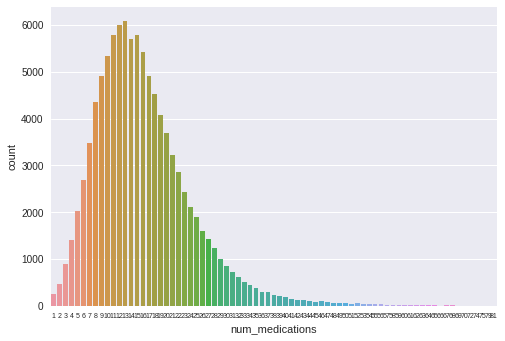

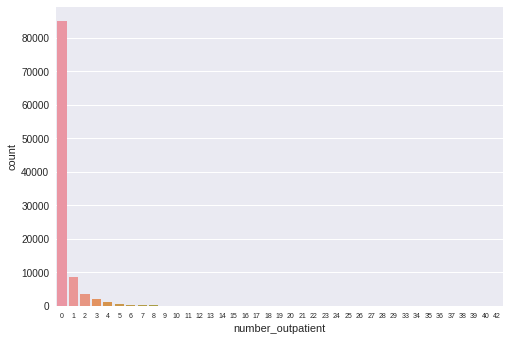

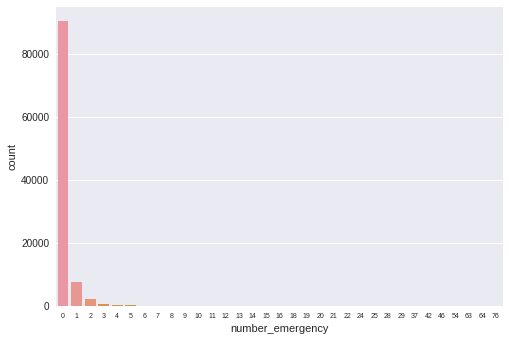

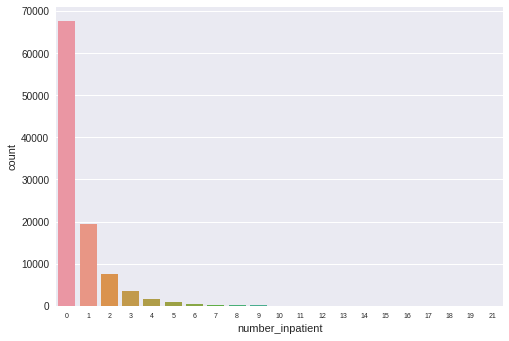

In [0]:

for a in ['num_medications','number_outpatient','number_emergency','number_inpatient']: #REVISAR ACABADOS
  var=sns.countplot(x=a,data=diabetes_completo)
  var.set_xticklabels(var.get_xticklabels(),fontsize=7)
  
  plt.show()



### Crear variables dummy en caso que sea conveniente

El caso que nos conviene más es el de la variable gender, que se puedde dividir fácilmente en M/F

In [0]:
dummies=pd.get_dummies(diabetes_completo['gender'])
dummies.shape

(101766, 3)

In [0]:
dummies.head() #verificamos que haya índice para concatenar

,Female,Male,Unknown/Invalid
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,1,0,0


In [0]:
#unimos diabetes_completo con dummy 
diabetes_dm=pd.concat([diabetes_completo,dummies],axis=1,join='inner')
diabetes_dm.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,metformin_pioglitazone,change,diabetesmed,readmitted,description_x,description_y,description,Female,Male,Unknown/Invalid
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,NO,Physician Referral,None,Not Mapped,1,0,0
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,Ch,Yes,>30,Physician Referral,None,Not Mapped,1,0,0
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,...,No,Ch,Yes,NO,Emergency Room,None,Not Mapped,0,1,0




### Estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

Revisado anteriormente. No vemos necesaria ninguna modificación en el formato. 
Por otra parte sí que nos parece oportuno cambiar los '?' en el caso específico del peso. 

In [0]:
diabetes_completo['weight']=[x.replace('?','n/d') for x in diabetes_completo['weight']]
diabetes_completo.head #sustituimos los interrogantes por n/d para que se vea que el peso no se ha medido.

<bound method NDFrame.head of         encounter_id  patient_nbr             race  gender       age weight  \
0       2278392       8222157      Caucasian        Female  [0-10)    n/d     
1       1968528       720936       Caucasian        Female  [70-80)   n/d     
2       2040360       661014       Caucasian        Male    [60-70)   n/d     
3       2088630       1719279      Caucasian        Male    [40-50)   n/d     
4       2091690       7919802      AfricanAmerican  Female  [40-50)   n/d     
5       2092362       5041602      Caucasian        Female  [70-80)   n/d     
6       2092848       6500556      Other            Male    [50-60)   n/d     
7       2095932       276606       AfricanAmerican  Female  [30-40)   n/d     
8       2135022       815391       Caucasian        Female  [80-90)   n/d     
9       2223336       558360       AfricanAmerican  Female  [60-70)   n/d     
10      2228292       6836652      Caucasian        Female  [60-70)   n/d     
11      2262036       

In [0]:
diabetes_completo.groupby(['weight']).agg('count') #vemos ahora los nuevos valores

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,description_x,description_y,description,time_in_hospital_range,readmitted_id
weight,,,,,,,,,,,,,,,,,,,,,
>200,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
[0-25),48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
[100-125),625,625,625,625,625,625,625,625,625,625,...,625,625,625,625,625,625,625,625,625,625
[125-150),145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
[150-175),35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
[175-200),11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
[25-50),97,97,97,97,97,97,97,97,97,97,...,97,97,97,97,97,97,97,97,97,97
[50-75),897,897,897,897,897,897,897,897,897,897,...,897,897,897,897,897,897,897,897,897,897
[75-100),1336,1336,1336,1336,1336,1336,1336,1336,1336,1336,...,1336,1336,1336,1336,1336,1336,1336,1336,1336,1336




### Antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

Estudiadas las variables, nos parece necesario crear:
- una variable derivada de time_in_hospital para que tenga tramos
- una variable readmitted_id que sea numérica para mirar luego su correlación


In [0]:
diabetes_completo.groupby(['time_in_hospital']).agg('count') #vemos cómo está distribuida

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,...,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,description_x,description_y,description
time_in_hospital,,,,,,,,,,,,,,,,,,,,,
1,14208,14208,14208,14208,14208,14208,14208,14208,14208,14208,...,14208,14208,14208,14208,14208,14208,14208,14208,14208,14208
2,17224,17224,17224,17224,17224,17224,17224,17224,17224,17224,...,17224,17224,17224,17224,17224,17224,17224,17224,17224,17224
3,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,...,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756
4,13924,13924,13924,13924,13924,13924,13924,13924,13924,13924,...,13924,13924,13924,13924,13924,13924,13924,13924,13924,13924
5,9966,9966,9966,9966,9966,9966,9966,9966,9966,9966,...,9966,9966,9966,9966,9966,9966,9966,9966,9966,9966
6,7539,7539,7539,7539,7539,7539,7539,7539,7539,7539,...,7539,7539,7539,7539,7539,7539,7539,7539,7539,7539
7,5859,5859,5859,5859,5859,5859,5859,5859,5859,5859,...,5859,5859,5859,5859,5859,5859,5859,5859,5859,5859
8,4391,4391,4391,4391,4391,4391,4391,4391,4391,4391,...,4391,4391,4391,4391,4391,4391,4391,4391,4391,4391
9,3002,3002,3002,3002,3002,3002,3002,3002,3002,3002,...,3002,3002,3002,3002,3002,3002,3002,3002,3002,3002


In [0]:
diabetes_completo['time_in_hospital_range']=diabetes_completo['time_in_hospital'] #creamos la columna

In [0]:
def intervalos(x): #definimos una función con los rangos. 
  #ENTRADA=variable numérica que vamos a convertir en rango
  #SALIDA=variable string con un intervalo
    intervalos = None
    if x < 4:
        intervalos = '[1-3)'
    elif x < 8:
        intervalos = '[4-7)'
    elif x < 12:
        intervalos = '[8-11)'
    else:
        intervalos = '>11'
    return intervalos

In [0]:
diabetes_completo['time_in_hospital_range'] = diabetes_completo['time_in_hospital'].apply(intervalos)
diabetes_completo.head()  #se aplica la función a la tabla principal

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,description_x,description_y,description,time_in_hospital_range
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,NO,Physician Referral,None,Not Mapped,[1-3)
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped,[8-11)
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,...,No,No,No,Ch,Yes,NO,Emergency Room,None,Not Mapped,[8-11)
3,2088630,1719279,Caucasian,Male,[40-50),?,6,25,7,11,...,No,No,No,Ch,Yes,>30,Emergency Room,None,Not Mapped,[8-11)
4,2091690,7919802,AfricanAmerican,Female,[40-50),?,6,25,7,6,...,No,No,No,No,No,NO,Emergency Room,None,Not Mapped,[4-7)


In [0]:
diabetes_completo.groupby(['readmitted']).agg('count') #vemos los valores de readmitted

In [0]:
def valores(x): #definimos una función con los valores 
  #ENTRADA=variable alfanumérica tipo rango que vamos a convertir a número
  #SALIDA=variable numérica 
    valores=None
    if x == 'NO':
        valores=1
    elif x== '<30':
        valores=2
    else:
        valores=3
    return valores

In [0]:
diabetes_completo['readmitted_id'] = diabetes_completo['readmitted'].apply(valores)
diabetes_completo.head()  #se aplica la función a la tabla principal

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,description_x,description_y,description,time_in_hospital_range,readmitted_id
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,NO,Physician Referral,None,Not Mapped,[1-3),1
1,1968528,720936,Caucasian,Female,[70-80),?,6,25,1,10,...,No,No,Ch,Yes,>30,Physician Referral,None,Not Mapped,[8-11),3
2,2040360,661014,Caucasian,Male,[60-70),?,6,25,7,9,...,No,No,Ch,Yes,NO,Emergency Room,None,Not Mapped,[8-11),1
3,2088630,1719279,Caucasian,Male,[40-50),?,6,25,7,11,...,No,No,Ch,Yes,>30,Emergency Room,None,Not Mapped,[8-11),3
4,2091690,7919802,AfricanAmerican,Female,[40-50),?,6,25,7,6,...,No,No,No,No,NO,Emergency Room,None,Not Mapped,[4-7),1




# Exploratory Data Analysis



### Crear la matriz de correlación

In [0]:
diabetes_completo.corr() #vemos la matriz de correlación


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_id
encounter_id,1.000000,0.512028,-0.158961,-0.132876,-0.112402,-0.062221,-0.026062,-0.014225,0.076113,0.103756,0.082803,0.030962,0.265149,-0.038416
patient_nbr,0.512028,1.000000,-0.011128,-0.136814,-0.032568,-0.024092,0.015946,-0.015570,0.020665,0.103379,0.062352,0.012480,0.226847,0.077315
admission_type_id,-0.158961,-0.011128,1.000000,0.083483,0.106654,-0.012500,-0.143713,0.129888,0.079535,0.026511,-0.019116,-0.038161,-0.117126,-0.001342
discharge_disposition_id,-0.132876,-0.136814,0.083483,1.000000,0.018193,0.162748,0.023415,0.015921,0.108753,-0.008715,-0.024471,0.020787,0.046891,-0.033281
admission_source_id,-0.112402,-0.032568,0.106654,0.018193,1.000000,-0.006965,0.048885,-0.135400,-0.054533,0.027244,0.059892,0.036314,0.072114,0.041193
time_in_hospital,-0.062221,-0.024092,-0.012500,0.162748,-0.006965,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186,0.040309
num_lab_procedures,-0.026062,0.015946,-0.143713,0.023415,0.048885,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773,0.035441
num_procedures,-0.014225,-0.015570,0.129888,0.015921,-0.135400,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734,-0.044150
num_medications,0.076113,0.020665,0.079535,0.108753,-0.054533,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526,0.037399
number_outpatient,0.103756,0.103379,0.026511,-0.008715,0.027244,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152,0.082255


filtramos a continuación para que muestre solo las correlaciones significativas. Al ejecutar vemos que no hay nada que supere un 0,5 y ponemos el umbral a 0,1 para comprobar que funciona el método aunque ningún valor correlacione.

In [0]:
diabetes_completo_corr=diabetes_completo.corr()['readmitted_id']
diabetes_completo_most_corr=diabetes_completo_corr[abs(diabetes_completo_corr) > 0.1].sort_values(ascending=False)
diabetes_completo_most_corr

readmitted_id       1.000000
number_inpatient    0.178208
number_diagnoses    0.104660
Name: readmitted_id, dtype: float64



### Pintar la matriz de correlación

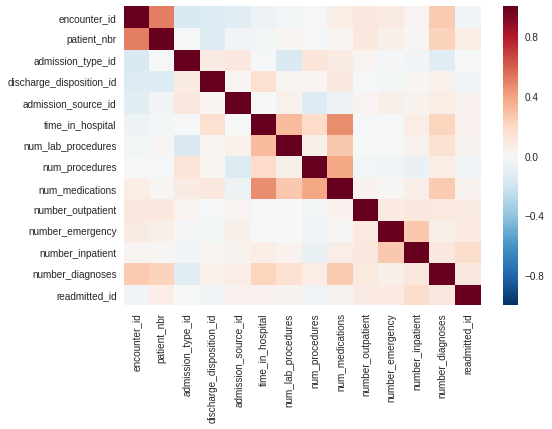

In [0]:
corr=diabetes_completo.corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)



### Determinar qué par de variables están correlacionadas

Por lo que vemos en la matriz de correlación, solo las variables time_in_hospital y num_medications presentan unos valores de correlación mínimamente significativos. Exploramos numéricamente ese caso.

In [0]:
diabetes_completo_corr=diabetes_completo.corr()['time_in_hospital']
diabetes_completo_most_corr=diabetes_completo_corr[abs(diabetes_completo_corr) > 0.3].sort_values(ascending=False)
diabetes_completo_most_corr

time_in_hospital      1.000000
num_medications       0.466135
num_lab_procedures    0.318450
Name: time_in_hospital, dtype: float64

Exploramos también el número de medicaciones

In [0]:
diabetes_completo_corr=diabetes_completo.corr()['num_medications']
diabetes_completo_most_corr=diabetes_completo_corr[abs(diabetes_completo_corr) > 0.3].sort_values(ascending=False)
diabetes_completo_most_corr

num_medications     1.000000
time_in_hospital    0.466135
num_procedures      0.385767
Name: num_medications, dtype: float64

Finalmente miramos la tercera variable con algo de correlación: num_procedures

In [0]:
diabetes_completo_corr=diabetes_completo.corr()['num_procedures']
diabetes_completo_most_corr=diabetes_completo_corr[abs(diabetes_completo_corr) > 0.3].sort_values(ascending=False)
diabetes_completo_most_corr

num_procedures     1.000000
num_medications    0.385767
Name: num_procedures, dtype: float64

Dado que ningún par de valores supera una correlación mutua de 0,5, concluimos que no se dan correlaciones significativas.

In [0]:
corr_matrix = diabetes_completo.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol[(sol > 0.3)]

      

encounter_id      patient_nbr           0.512028
time_in_hospital  num_medications       0.466135
num_procedures    num_medications       0.385767
time_in_hospital  num_lab_procedures    0.318450
dtype: float64